In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

import warnings
warnings.filterwarnings('ignore')

def mkdf(columns, importances):
    I = pd.DataFrame(data={'Feature':columns, 'Importance':importances})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I

def plot_importances(df_importances, save=None, xrot=0, tickstep=3, scalefig=(1.0,1.0)):
    """
    Given an array or data frame of importances, plot a horizontal bar chart
    showing the importance values.
    """
    I = df_importances

    fig = plt.figure()
    w, h = fig.get_size_inches()
    fig.set_size_inches(w*scalefig[0], h*scalefig[1], forward=True)
    ax = plt.gca()
    ax.barh(np.arange(len(I.index)), I.Importance, height=.7, tick_label=I.index)

    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect((x1 - x0) / (y1 - y0))

    # rotate x-ticks
    if xrot is not None:
        plt.xticks(rotation=xrot)

    # xticks freq
    xticks = ax.get_xticks()
    nticks = len(xticks)
    new_ticks = xticks[np.arange(0, nticks, step=tickstep)]
    ax.set_xticks(new_ticks)

    plt.tight_layout()
    if save:
        plt.savefig(save, bbox_inches="tight", pad_inches=0.03)
    plt.show()

In [3]:
df = pd.read_csv("data/rent.csv")
features = ['bathrooms','bedrooms','price','longitude','latitude',
            'interest_level']
df = df[features].copy()
df.to_csv("data/rent-numeric.csv", index=False)
df.head(5)

,bathrooms,bedrooms,price,longitude,latitude,interest_level
0,1.5,3,3000,-73.9425,40.7145,2
1,1.0,2,5465,-73.9667,40.7947,1
2,1.0,1,2850,-74.0018,40.7388,3
3,1.0,1,3275,-73.9677,40.7539,1
4,1.0,4,3350,-73.9493,40.8241,1


# Built-in scikit importances

0.716060139407


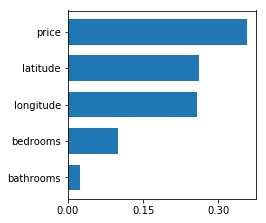

0.713547576593


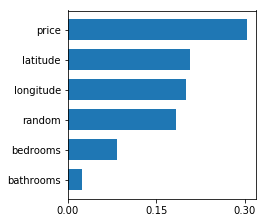

In [4]:
base_rf = RandomForestClassifier(n_estimators=100,
                                 min_samples_leaf=5,
                                 n_jobs=-1,
                                 oob_score=True)

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']

rf = clone(base_rf)
rf.fit(X_train, y_train)
print(rf.oob_score_)
I = mkdf(X_train.columns,rf.feature_importances_)            
plot_importances(I, scalefig=(1.0,0.8), save='../article/images/cls_dflt.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train2))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)
print(rf2.oob_score_)
I = mkdf(X_train2.columns,rf2.feature_importances_)
plot_importances(I, scalefig=(1.0,0.8), save='../article/images/cls_dflt_random.svg')

# Importances via dropping columns and retraining

In [43]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = clone(rf)
    rf_.random_state = 999
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        imp.append(baseline - o)
    return np.array(imp)

def classifier_dropping_importances_cv(rf, X_train, y_train, k=5):
    rf_ = clone(rf)
    rf.random_state = 999
    rf_.fit(X_train, y_train)
    
    cvscore = cross_val_score(clone(rf), X_train, y_train, cv=k, scoring='accuracy')
    m_base = cvscore.mean()
    print(f"{k}-fold cross-validation accuracy {m_base:.4f}")
                              
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = clone(rf)
        rf_.random_state = 999
        rf_.fit(X, y_train)
        
        cvscore = cross_val_score(clone(rf_), X, y_train, cv=5, scoring='accuracy')
        m = cvscore.mean()
        print(f"drop {col} {k}-fold cross-validation accuracy {m:.4f}")
        imp.append(m_base - m)
        
    return np.array(imp)

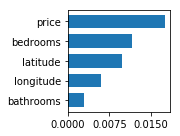

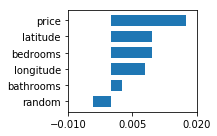

In [52]:
# max_features=n_features for regressors but sqrt for classifiers

X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']
rf = clone(base_rf)
imp = dropcol_importances(rf, X_train, y_train)
I = mkdf(X_train.columns,imp)
plot_importances(I, save='../article/images/cls_dropcol.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train2))
rf2 = clone(base_rf)
imp = dropcol_importances(rf2, X_train2, y_train)
I = mkdf(X_train2.columns,imp)
plot_importances(I, save='../article/images/cls_dropcol_random.svg')

# Importances via column permutation

In [45]:
from sklearn.ensemble.forest import _generate_unsampled_indices

# TODO: add arg for subsample size to compute oob score

def oob_classifier_accuracy(rf, X_train, y_train):
    X = X_train.values
    y = y_train.values

    n_samples = len(X)
    n_classes = len(np.unique(y))
    predictions = np.zeros((n_samples, n_classes))
    for tree in rf.estimators_:
        unsampled_indices = _generate_unsampled_indices(tree.random_state, n_samples)
        tree_preds = tree.predict_proba(X[unsampled_indices, :])
        predictions[unsampled_indices] += tree_preds

    predicted_class_indexes = np.argmax(predictions, axis=1)
    predicted_classes = [rf.classes_[i] for i in predicted_class_indexes]

    oob_score = np.mean(y == predicted_classes)
    return oob_score

def permutation_importances(rf, X_train, y_train, metric):
    """
    Return importances from pre-fit rf; metric is function
    that measures accuracy or R^2 or similar. This function
    works for regressors and classifiers.
    """
    baseline = metric(rf, X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(rf, X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

oob accuracy 0.717012481764


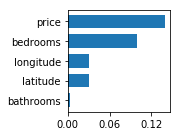

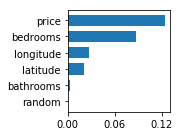

In [51]:
X_train, y_train = df.drop('interest_level',axis=1), df['interest_level']
rf = clone(base_rf)
rf.fit(X_train, y_train)
oob = oob_classifier_accuracy(rf, X_train, y_train)
print("oob accuracy",oob)

imp = permutation_importances(rf, X_train, y_train,
                              oob_classifier_accuracy)
I = mkdf(X_train.columns,imp)
plot_importances(I, save='../article/images/cls_permute.svg')

X_train2 = X_train.copy()
X_train2['random'] = np.random.random(size=len(X_train))
rf2 = clone(base_rf)
rf2.fit(X_train2, y_train)

imp = permutation_importances(rf2, X_train2, y_train,
                            oob_classifier_accuracy)
I = mkdf(X_train2.columns,imp)
plot_importances(I, save='../article/images/cls_permute_random.svg')